#Introduction




--------------------------------------
 **Transfer Learning**
 "Transfer learning is a machine learning method where a model developed for a task is reused as the starting point for a model on a second task". Text-based transfer learning based methods (particularly those based on transformers) are starting to find traction being applied towards the chemical domain [(Schwaller et al, 2021)]." For example, transformer based methods can be used to infer reaction classes (e.g. classes  which organize chemical reaction space and allow for the communication of complex concepts)  from non-annotated,
simple text-based representations of chemical reactions. Performance can be strong with classification accuracy reaching  98.2%."
(Schwaller et al, 2021)


**Transformer based learning**

**Masked token Prediction**
Masked Language Modeling is a self-supervised pretraining objective that is widely used in natural language processing for learning text representations. In Masked Language Modeling a model is trained to predict input tokens that have been replaced by a placeholder. Tokens are the partitions of a text, and generally fall into familiar categories such as words, individual characters, or subwords (e.g. the subwords smart and er for the word smarter). An example masked sentence could look like:

Example:
*sentence:*
 The quick brown [MASK] jumps over the lazy dog.

*masked sentence:*
The quick brown [MASK] jumps over the lazy dog. 

The string [MASK] acts as a placeholder. 


**SMILES, textual chemical representations**
While chemical structres are typically represented as graphs, the simplified molecular-input line-entry system (SMILES)  was introduced as notation for encoding molecular structures into ASCII strings in the 1980's. There is not a one to one mapping of structures with SMILES strings as a single structure can have a number of equally valid SMILES strings. These strings are composed of characters which indicate the connectivity of atoms through bonds and also include explict representation of cycles. (EPA SMILES TUTORIAL).

**Masked Token Prediction using SMILES representation**
Like natural language sentences can be broken down into tokens and used for masked language modeling, SMILES strings can also be tokenized and masked as shown in the example of acetone below. 

*Example:* 

SMILES Representation:
CC(=O)C

Masked SMILES Representation:
CC([MASK]O)C

Chemically Valid Masked Token Solutions:
1. CC(=O)C
2. CC(-O)C
3. CC(NO)C
4. CC(CO)C




**Visualization Learning Objectives**

  1.   Visualize sets of molecules in a compact way 

  (i)*Array of predictions*: [![ predictions of masked acetone](https://github.com/deloragaskins/data_science_public/blob/create_tutorials/DK_tutorials/images/acetone_predictions.png)](https://github.com/deloragaskins/data_science_public/blob/create_tutorials/DK_tutorials/images/acetone_predictions.png )

  
  2.   Highlight substructures of interest:
   
   (i) highlight specific bonds or atoms:

        *masked chemical structure*
[![acetone showing location of mask](https://github.com/deloragaskins/data_science_public/blob/144be523b6645a21b75753dc810040098824318e/DK_tutorials/acetone_mask.png)](https://github.com/deloragaskins/data_science_public/blob/144be523b6645a21b75753dc810040098824318e/DK_tutorials/acetone_mask.png )

    (ii)  highlight structure differences:

    *Differences between original and prediction*:
[![acetone vs another solution to mask](https://github.com/deloragaskins/data_science_public/blob/144be523b6645a21b75753dc810040098824318e/DK_tutorials/compare_differences_in_masked_prediction.png)](https://github.com/deloragaskins/data_science_public/blob/144be523b6645a21b75753dc810040098824318e/DK_tutorials/compare_differences_in_masked_prediction.png )






**Example Problem Outline**
We will use a pretrained model to make a prediction of a masked token for SMILES representation of a molecule that is in the ClinTox datahase. 

*Select molecule*
*   Load Clintox database
*   Explore first 25 structures* (LO1)
*   Choose a structure and highlight functional groups/substructures (LO2)

*Make masked token prediction*
*   Highlight mask* (LO2)
*   Set up ML algorithm
*   Run ML

*Interpret results*
*   show predictions grouped* (LO1)
*   compare predictions and original* (LO2)
*   check in database
*   check for toxicity

*Benefit from visualisation

LO1: Learning Objective 1

LO2: Learning Objective 2

*Citations*
[ Schwaller et al](https://arxiv.org/abs/2012.06051)

[EPA SMILES TUTORIAL](https://archive.epa.gov/med/med_archive_03/web/html/smiles.html)


#Colab
This tutorial and the rest in this sequence can be done in Google colab. If you'd like to open this notebook in colab, you can use the following link.


<a href="https://colab.research.google.com/github/deloragaskins/data_science_public/blob/main/ChemAsh5_VisualizingMasking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Preamble

In [1]:
 #suppressing output from this cell in colab
%%capture

!pip install --pre deepchem
!pip install rdkit-pypi

#to access ClinTox_ *database which has information about the toxicity of a set of molecules*
# import MolNet dataloder from bert-loves-chemistry fork
!git clone https://github.com/seyonechithrananda/bert-loves-chemistry.git
%cd /content/bert-loves-chemistry
!pwd
from chemberta.utils.molnet_dataloader import load_molnet_dataset, write_molnet_dataset_for_chemprop

#to play with and display chemical structures
import rdkit
import rdkit.Chem as Chem
from rdkit.Chem import Draw as ChemDraw
from rdkit.Chem.Draw import MolToImage

import matplotlib.pyplot as plt
from matplotlib import colors

import rdkit.Chem.rdFMCS as rdFMCS


In [2]:

#tools for making the predictions 
!pip install transformers
from transformers import AutoModelForMaskedLM, AutoTokenizer, pipeline, RobertaModel, RobertaTokenizer
import torch

#Select Molecule 


1. Load Clintox database
2. Explore first 25 structures* (LO1)
3. Choose 1 molecule for masked token prediction


We load the ClinTox dataset into a dataframe with SMILES representations and toxicity for each molecule.  



In [3]:
tasks, (train_df, valid_df, test_df), transformers = load_molnet_dataset("clintox", tasks_wanted=None)
full_ClinTox_df = train_df.append(valid_df, ignore_index=True)
full_ClinTox_df=full_ClinTox_df.append(test_df, ignore_index=True)


'split' is deprecated.  Use 'splitter' instead.


Using tasks ['CT_TOX'] from available tasks for clintox: ['FDA_APPROVED', 'CT_TOX']



We take a look at the SMILES for the first 25 and visualize their structures

In [4]:
length_peek=25
full_ClinTox_df['text'].head(length_peek)

0         CC(C)C[C@H](NC(=O)CNC(=O)c1cc(Cl)ccc1Cl)B(O)O
1     O=C(NCC(O)CO)c1c(I)c(C(=O)NCC(O)CO)c(I)c(N(CCO...
2                              Clc1cc(Cl)c(OCC#CI)cc1Cl
3     N#Cc1cc(NC(=O)C(=O)[O-])c(Cl)c(NC(=O)C(=O)[O-])c1
4                NS(=O)(=O)c1cc(Cl)c(Cl)c(S(N)(=O)=O)c1
5                       NC(N)=[NH+]C(=O)Cc1c(Cl)cccc1Cl
6                         [NH3+]C[C@H](O)c1ccc(O)c(O)c1
7                [NH3+][C@@H](Cc1ccc(O)c(O)c1)C(=O)[O-]
8                                [NH3+]CCc1ccc(O)c(O)c1
9                               Nc1ccc(O)c(C(=O)[O-])c1
10                              Nc1ccc(C(=O)[O-])c(O)c1
11                         NC(N)=[NH+]Cc1cccc([131I])c1
12    O=C(N[C@H](CO)[C@H](O)c1ccc([N+](=O)[O-])cc1)[...
13    O=C([O-])CCC(=O)OC[C@@H](NC(=O)[C-](Cl)Cl)[C@H...
14                     [NH3+]CC(CC(=O)[O-])c1ccc(Cl)cc1
15                          Nc1ccc(C(=O)NCC(=O)[O-])cc1
16        [NH3+][C@@H](Cc1ccc(N(CCCl)CCCl)cc1)C(=O)[O-]
17                  [NH3+][C@@H](Cc1ccc(O)cc1)C(

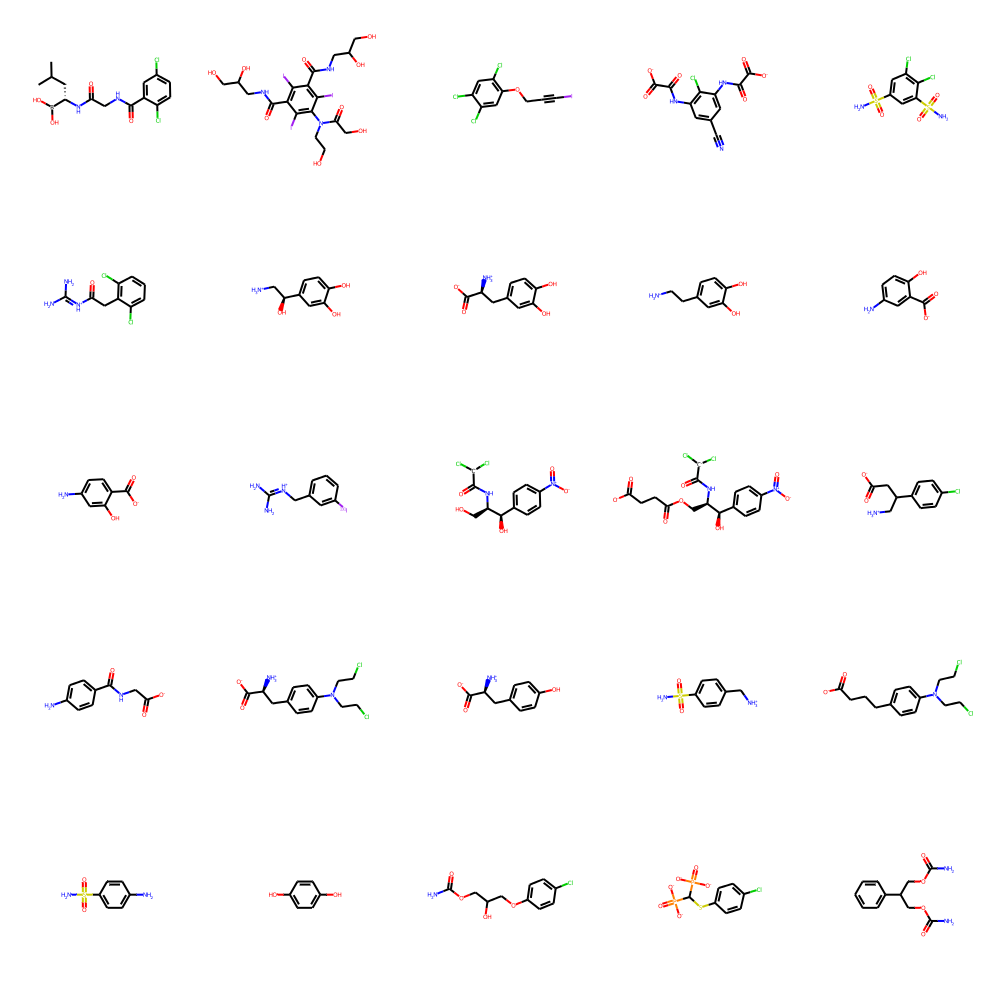

In [5]:

ms = [Chem.MolFromSmiles(x) for x in full_ClinTox_df['text'][:length_peek]]
ChemDraw.MolsToGridImage(ms,molsPerRow=5)


From these structures, we focus on fairly simple molecule for masked token prediction. 

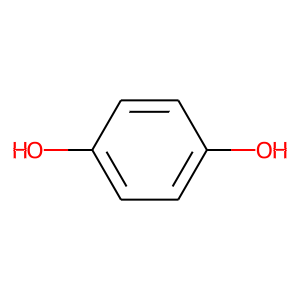

In [6]:
molecule_num=4*5+1
molecule_str=full_ClinTox_df['text'][molecule_num]
molecule=Chem.MolFromSmiles(molecule_str) 
ChemDraw.MolToImage(molecule)

# Make a masked token prediction 




1. Highlight mask* (LO2)
2.Set up ML algorithm
3.Run ML



There are two chemically identical substitutions on the aromatic ring here which are represented with different characters in the original SMILES representation. Here we visualize each individually. 

In [7]:
#function to select substruct if there are multiple matches
def extract_nth_substructure(substructures,n):
  if len(substructures)>1:
    print('This substructure occurs in multiple places in the molecule')
  elif len(substructures)==1:
    print('This substructure occurs only once in the molecule')
  else:
    print('This substructure does not appear in the molecule.')
  Atoms_list=[]  
  substructure=substructures[n]
  for atom_counter in range(len(substructure)):
    Atoms_list.append(substructure[atom_counter])

  hit_bonds=[]
  for bond in Chem.MolFromSmarts(substructure_smarts).GetBonds():
      aid1 = Atoms_list[bond.GetBeginAtomIdx()]
      aid2 = Atoms_list[bond.GetEndAtomIdx()]
      hit_bonds.append(molecule.GetBondBetweenAtoms(aid1,aid2).GetIdx())
  Bonds_list=hit_bonds
  return Atoms_list,Bonds_list

#################################################################################
def image_of_nth_substructure(substructure_smarts,molecule_smiles,n):
  m=Chem.MolFromSmiles(molecule_smiles)
  
  #check for multiples
  substructures=m.GetSubstructMatches(Chem.MolFromSmarts(substructure_smarts))
  Atoms_list,Bonds_list=extract_nth_substructure(substructures,n)
  #highlight
  hcolor = colors.to_rgb('violet')
  img = MolToImage(m, size=(600, 600),fitImage=True,highlightAtoms=Atoms_list,highlightColor=hcolor)
  return img

This substructure occurs in multiple places in the molecule
This substructure occurs in multiple places in the molecule


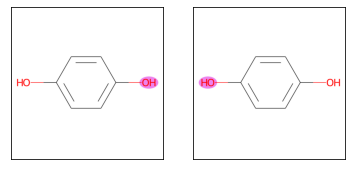

In [8]:
substructure_smarts='O'
molecule_smiles=molecule_str

number_of_hits=2
number_of_rows=1
number_of_columns=number_of_hits
for n in range(number_of_hits):
  plt.subplot(number_of_rows,number_of_columns,n+1)
  plt.imshow(image_of_nth_substructure(substructure_smarts,molecule_smiles,n))
  plt.xticks([])
  plt.yticks([])



Here we select the model for the masked token prediction detailed further in Transfer_Learning_With_ChemBERTa_Transformers notebook in the tutorials. 

We also select to mask the hydroxyl group that is represented in the middle of the SMILES representation for this molecule.

In [9]:
#functions to streamline prediction section
def addmask(molecule_str,mask_str,mask_start_pos,mask_end_pos):
  masked=''
  for counter0 in range(len(molecule_str)):
    if mask_len>0:
      if counter0 in range(mask_start_pos,mask_end_pos):
        masked+=''
      elif counter0 == mask_end_pos:
        masked+=mask_str
      else:
        masked+=molecule_str[counter0]
    else:
        masked+=molecule_str[counter0]
  #print(masked)
  return masked

def predict_n(sequence,n):
  input = tokenizer.encode(sequence, return_tensors="pt")
  mask_token_index = torch.where(input == tokenizer.mask_token_id)[1]

  token_logits = model(input)[0]
  mask_token_logits = token_logits[0, mask_token_index, :]
  top_n_tokens = torch.topk(mask_token_logits, n, dim=1).indices[0].tolist()
  #print(top_n_tokens)

  valid_mols_list=[]
  for token in top_n_tokens:
    smi = (sequence.replace(tokenizer.mask_token, tokenizer.decode([token])))
    print (smi)
    smi_mol = Chem.MolFromSmiles(smi)
    if smi_mol is None: # if the model's token prediction isn't chemically feasible
      continue
    valid_mols_list.append((smi))
  return valid_mols_list

################################################################################

In [10]:
#setup machine learning alg: details 

#take pretrained model and define the pipeline
model = AutoModelForMaskedLM.from_pretrained("seyonec/PubChem10M_SMILES_BPE_450k")
tokenizer = AutoTokenizer.from_pretrained("seyonec/PubChem10M_SMILES_BPE_450k")

fill_mask = pipeline('fill-mask', model=model, tokenizer=tokenizer)

In [11]:
#Make valid predictions for single masked position 
Cell_label='Make Predictions'

mask_start_pos=7
mask_char_type='atom' #'bond' #'atom','ring'

mask_end_pos=mask_start_pos
mask_len=mask_end_pos-mask_start_pos+1
mask_str='<mask>'

smiles_mask=addmask(molecule_str,mask_str,mask_start_pos,mask_end_pos)
replaced=molecule_str[mask_start_pos:mask_end_pos+mask_len]

sequence = smiles_mask.replace('<mask>',tokenizer.mask_token)

print(molecule_str)
print(replaced)

n1=5
valid_smi_list=predict_n(sequence,n1)

Oc1ccc(O)cc1
O
Oc1ccc(O)cc1
Oc1ccc(Cl)cc1
Oc1ccc(Br)cc1
Oc1ccc(I)cc1
Oc1ccc(F)cc1


# Interpret Results

1. show predictions grouped* (LO1)
2. compare predictions and original* (LO2)
3. check in database
4. check for toxicity

We show the results of the prediction as both SMILES and chemical structures. In addition, several additional valid structures are predicted.. 

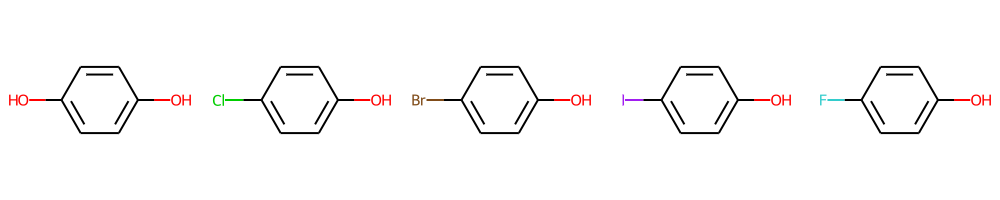

In [12]:
Cell_label='Show Prediction results'

valid_mols_list=[Chem.MolFromSmiles(x) for x in valid_smi_list ]

ChemDraw.MolsToGridImage(valid_mols_list,molsPerRow=n1)

In [13]:
def difference_Hs_2(mol1, mol2):
    mol1=Chem.AddHs(mol1)
    mol2=Chem.AddHs(mol2)
    mcs = rdFMCS.FindMCS([mol1,mol2])
    mcs_mol = Chem.MolFromSmarts(mcs.smartsString)
    match2 = mol2.GetSubstructMatch(mcs_mol)
    target_atm2 = []
    for atom in mol2.GetAtoms():
        if atom.GetIdx() not in match2:
            target_atm2.append(atom.GetIdx())
    return target_atm2




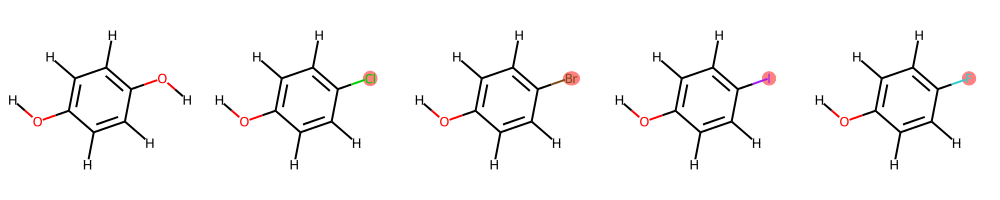

In [14]:
originalmol=molecule
HighlightDiffList=[]
valid_mols_list_Hs=[]
for mols in valid_mols_list:
  HighlightDiffList.append(difference_Hs_2(originalmol, mols))
  valid_mols_list_Hs.append(Chem.AddHs(mols))

ChemDraw.MolsToGridImage(valid_mols_list_Hs,highlightAtomLists=HighlightDiffList,molsPerRow=len(valid_mols_list))


We see that this structure in not present in ClinTox but that it does have some toxicity.

In [15]:
################################################################################
#function to support the querying of ClinTox
def canon_smiles(text):
  #Cell_label='Check Clintox for Prediction'
  text=Chem.MolToSmiles(Chem.MolFromSmiles(text))
  return text

In [17]:
Cell_label='Check Clintox for Prediction'
pred_1=valid_mols_list_Hs[1]
full_ClinTox_df['canonical_smiles']= full_ClinTox_df['text'].apply(canon_smiles)
print(full_ClinTox_df[full_ClinTox_df['canonical_smiles'].str.match(Chem.MolToSmiles(pred_1))])

Empty DataFrame
Columns: [text, labels, canonical_smiles]
Index: []


In [ ]:
#Toxicity information for predicted compound
#https://pubchem.ncbi.nlm.nih.gov/compound/4684#section=Toxicity

#Congratulations! Time to join the Community!
Congratulations on completing this tutorial notebook! If you enjoyed working through the tutorial, and want to continue working with DeepChem, we encourage you to finish the rest of the tutorials in this series. You can also help the DeepChem community in the following ways:

#Star DeepChem on Github
This helps build awareness of the DeepChem project and the tools for open source drug discovery that we're trying to build.

#Join the DeepChem Gitter
The DeepChem Gitter hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!